In [1]:
from model_utils import *

In [5]:
MODEL_NAME = 'skimai/spanberta-base-cased'
FILE = 'data/augmented_elmundo_1124.json'
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 1
CATE_LIMIT = 10
CATE_USE = 3
TASK = 'Soft-presentation'

In [6]:
import datetime
TODAY = datetime.date.today().strftime("%m%d")
RESULT_DIR = 'results/{}-results-{}'.format(TASK,TODAY)
SUB_DIR = 'Soft-Presentation'
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
if not os.path.exists("{}{}".format(RESULT_DIR,SUB_DIR)):
    os.makedirs("{}{}".format(RESULT_DIR,SUB_DIR))
OUTPUT_PATH = RESULT_DIR + SUB_DIR

In [7]:
# load data
labels,contents,lset,ldic = load_test_data(FILE,CATE_LIMIT,percentage=1)

# encode 1 87s
start = time.time()
encodings_list = pre_encode_list(MODEL_NAME,contents,MAX_SEQ_LENGTH)
print('encoding time cost :',time.time()-start)

# load dataset
train_dataset = NewsCategoryDataset(labels, encodings_list, contents, ldic)
valid_dataset = NewsCategoryDataset(labels, encodings_list, contents, ldic, 'val')
test_dataset = NewsCategoryDataset(labels, encodings_list, contents, ldic, 'test')
print('data loaded \ntrain:{}\nvalid:{}\ntest:{}'.format(len(train_dataset),
                                                          len(valid_dataset),
                                                          len(test_dataset)))

# dataloader
train_val_loaders = {
    "train": DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True),
    "valid": DataLoader(dataset=valid_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False),
    "test": DataLoader(dataset=test_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False)
}

Data loaded:  70 70


100%|██████████| 70/70 [00:00<00:00, 3019.38it/s]

Tokenizer loaded...
encoding time cost : 5.00314998626709
data loaded 
train:49
valid:11
test:10


In [28]:
MODEL_NAME = 'skimai/spanberta-base-cased'
pmodel = 'results/NewsCate-finetune-1121/3e-05-128/1121-epoch-3.pth'
model1 = 'results/elmundo_on_trained-1202/3e-05-128/1202-epoch-4.pth'
model2 = 'results/elmundo_raw_model-results-1202/3e-05-128/1202-epoch-4.pth'
MODELS = [MODEL_NAME,pmodel,model1,model2]
MODELNAMES = ['Raw','NewsCate',"Further",'Elmundo']
CATES = [26,26,7,7]

In [15]:
bert_results = []
cls_results = []
tars = []
allowed_cates = [i for i in range(1)]
for idx,(m, ca) in enumerate(zip(MODELS,CATES)):
    model = RobertaForSequenceClassification(MODEL_NAME,ca)
    if m != MODEL_NAME:
        model.load_dict(m,ca,True)
    b_result = []
    c_result = []
    lab = []
    if torch.cuda.is_available():
        model = nn.DataParallel(model)
        model.cuda()
    model.eval()
    with torch.no_grad():
        for _,data in enumerate(notetqdm(train_val_loaders['train'])):
            features = data['input_ids'].cuda()
            # print(features.shape)
            att_mask = data['attention_mask'].cuda()
            target = data['targets']
            if target in allowed_cates:
                # print(att_mask.shape)
                bert_out = model.module.bert(features,att_mask)
                # print(type(target))
                blist = bert_out[0].tolist()
                clist = bert_out[0][:, 0].tolist()
                tar = target.tolist()[0]
                # print(type(tar))
                b_result.append(blist)
                c_result.append(clist)
                lab.append(tar)
           
    bert_results.append(b_result)
    cls_results.append(c_result)
    tars.append(lab)

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [17]:
len(bert_results), len(cls_results), len(tars)

(4, 4, 4)

In [16]:
len(bert_results[0]), len(cls_results[0]), len(tars[0])

(7, 7, 7)

## 2D

In [18]:
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import MDS

In [20]:
mds2 = MDS(n_components=2)
trans_2d = []
for x in cls_results:
    x = np.squeeze(x)
    x_transformed = mds2.fit_transform(x)
    trans_2d.append(x)

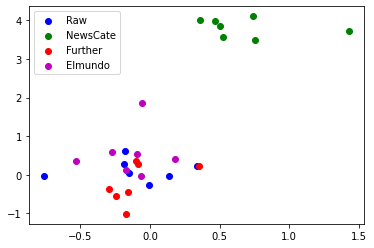

<Figure size 800x1600 with 0 Axes>

In [33]:
colors = ['b','g','r','m']
#colors = tuple([(np.random.random(),np.random.random(),np.random.random()) for i in range(CATE_USE)])
fig = plt.figure()
plt.figure(figsize=(2,4), dpi=400)
ax = fig.add_subplot(1,1,1)
for idx,pots in enumerate(trans_2d):
    xs, ys, cs, ts = pots[:,0], pots[:,1], colors[idx], MODELNAMES[idx]
    # print(len(xs),len(ys))
    ax.scatter(xs,ys,c=cs,label=ts)
    ax.legend()
fig.savefig('2d_cluster')

## 3d

In [34]:
'''
mds3 = MDS(n_components=3)
x = np.squeeze(cls_results[0])
x.shape
x_transformed = mds3.fit_transform(x)
x_transformed.shape
'''
mds3 = MDS(n_components=3)
trans_3d = []
for x in cls_results:
    x = np.squeeze(x)
    x_transformed = mds3.fit_transform(x)
    trans_3d.append(x)

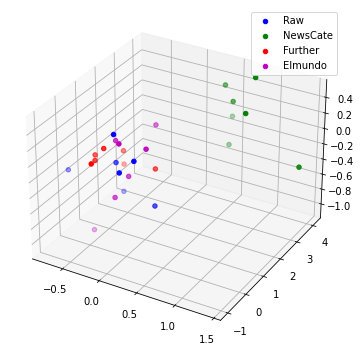

<Figure size 800x1600 with 0 Axes>

In [36]:
colors = ['b','g','r','m']
fig = plt.figure()
#colors = tuple([(np.random.random(),np.random.random(),np.random.random()) for i in range(CATE_USE)])
plt.figure(figsize=(2,4), dpi=400)
ax = fig.add_subplot(projection='3d')
fig.subplots_adjust(top=5, bottom=-5)
for idx,pots in enumerate(trans_2d):
    xs, ys, zs, cs, ts = pots[:,0], pots[:,1], pots[:,2], colors[idx], MODELNAMES[idx]
    # print(len(xs),len(ys))
    ax.scatter(xs, ys, zs, c=cs,label=ts)
    ax.legend()
fig.savefig('2d_cluster')

In [3]:
a = torch.Tensor([1])

In [6]:
if a in [1,2]:
    print(a)

tensor([1.])


In [ ]:
type(a.tolist()[0])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


label_set = list(set(tars[0]))

ax.scatter(xs,ys,zs,c=cs,label=ts)

#legend = ax.legend(loc='best')
fig.savefig('cluster')

In [3]:
MLP = nn.Linear(10,2)

In [6]:
MLP.out_features

2